In [11]:
### Pyhton 3.7.1 ###
#-----L3 RM-ANOVA------
#~~packages
import pandas as pd
import scipy.stats as stats
import numpy as np
#numba
import numba as nb
from numba import jit
#time
import time
tStart = time.time()
#install scipy
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
#install matplotlib
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
#data visualization
import seaborn as sns

In [12]:
#~~ loading data
df_raw = pd.read_csv(r"C:\Users\johnson_yang\Desktop\WOW_data_forStudent.csv")#改成自己的檔案位置
print(df_raw.head())

   Unnamed: 0       ID  ethnic  gender  senson  school_3  school_2  school_1  \
0           3  1041002  Human        0       1       206       204       102   
1          15  1041007  Human        0       1       101       101       101   
2          16  1041008  Human        0       1       103       103       103   
3          30  1041012  Human        1       1       104       104       104   
4          64  1041020  Human        0       1       107       107       107   

   eco_3  eco_2   ...    item12  item13  item14  item15  item16  item17  \
0      0      0   ...         4       1       4       4       1       5   
1      1      1   ...         5       1       5       5       1       5   
2      0      0   ...         4       1       4       4       1       5   
3      1      1   ...         3       1       2       2       1       2   
4      0      0   ...         5       1       5       5       1       5   

   item19  item20  item21  item22  
0       4       4       1       

In [13]:
#~~ checking data
df = df_raw[['ID','reading_1','reading_2','reading_3']]
print('---------------------Data info_head---------------------')
print(df.head())
print('---------------------Data type---------------------')
print(df.dtypes)
print('---------------------ID info---------------------')
print(df.describe())
df[['ID']]=df[['ID']].astype('object')
print(df.dtypes)


---------------------Data info_head---------------------
        ID  reading_1  reading_2  reading_3
0  1041002        472        478        492
1  1041007        478        486        494
2  1041008        500        505        523
3  1041012        431        457        476
4  1041020        500        502        515
---------------------Data type---------------------
ID           int64
reading_1    int64
reading_2    int64
reading_3    int64
dtype: object
---------------------ID info---------------------
                 ID   reading_1   reading_2   reading_3
count  1.930000e+02  193.000000  193.000000  193.000000
mean   1.041097e+06  477.264249  488.865285  499.326425
std    5.585845e+01   21.475461   19.109402   19.092761
min    1.041001e+06  393.000000  420.000000  423.000000
25%    1.041049e+06  467.000000  480.000000  489.000000
50%    1.041097e+06  481.000000  492.000000  503.000000
75%    1.041145e+06  489.000000  500.000000  512.000000
max    1.041193e+06  530.000000  537.00

In [14]:
# ~~ melt for RM-ANOVA
RM_data= pd.melt(df, id_vars=['ID'], value_vars=['reading_1','reading_2','reading_3'],var_name='read_time', value_name='score')
print(RM_data.head())
print(np.count_nonzero(RM_data['ID']))

        ID  read_time  score
0  1041002  reading_1    472
1  1041007  reading_1    478
2  1041008  reading_1    500
3  1041012  reading_1    431
4  1041020  reading_1    500
579


In [15]:
# ~~ homogeneity
print(stats.bartlett(df['reading_1'],df['reading_2'], df['reading_3']))
print(stats.levene(df['reading_1'],df['reading_2'],df['reading_3']))

BartlettResult(statistic=3.5918919210341254, pvalue=0.16597037664153358)
LeveneResult(statistic=0.577425875298038, pvalue=0.5616660669699498)


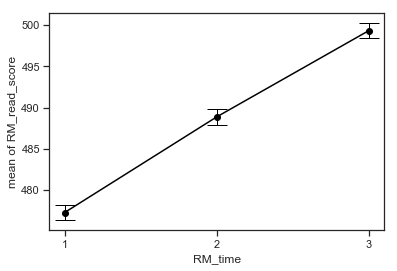

In [16]:
# plot
plt.errorbar([1,2,3],[np.mean(np.array(df['reading_1']).astype(np.float)),np.mean(np.array(df['reading_2']).astype(np.float)),np.mean(np.array(df['reading_3']).astype(np.float))],yerr=0.95,fmt='-o',ecolor='black',color='black',elinewidth=1,capsize=10)
plt.xlabel(xlabel='RM_time')
plt.xticks(np.linspace(1, 3, 3))
plt.ylabel(ylabel='mean of RM_read_score')
plt.show()

In [17]:
# ~~RM anova
import pingouin as pi

print('-----------------RM ANOVA------------------')
score_mean=(sum(RM_data['score']))/np.count_nonzero(RM_data['score'])
SST=[]
for i in RM_data['score']:
    x=(i-score_mean)**2
    SST.append(x)

print('Sum of square total=',sum(SST))
print('Degree of freedom total=',(np.count_nonzero(RM_data['score'])-1))
print('-------------------------------------------')

rmaov_res = pi.rm_anova(dv='score',within='read_time',subject='ID',data=RM_data,detailed=True,correction=True)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(rmaov_res)

-----------------RM ANOVA------------------
Sum of square total= 275664.6252158895
Degree of freedom total= 578
-------------------------------------------
      Source         SS   DF         MS        F         p-unc    p-GG-corr  \
0  read_time  47012.169    2  23506.085  501.319  8.60286e-108  1.7567e-101   
1      Error  18005.164  384     46.888        -             -            -   

     np2   eps sphericity W-spher     p-spher  
0  0.723  0.94      False   0.936  0.00177918  
1      -     -          -       -           -  


In [18]:
# ~~post hoc
print('-----------------post hoc------------------')
rmaov_post=pi.pairwise_tukey(dv='score', between='read_time', data=RM_data, alpha=0.05, tail='two-sided', effsize='hedges')
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(rmaov_post)

-----------------post hoc------------------
           A          B     mean(A)     mean(B)       diff     SE       tail  \
0  reading_1  reading_2  477.264249  488.865285 -11.601036  2.028  two-sided   
1  reading_1  reading_3  477.264249  499.326425 -22.062176  2.028  two-sided   
2  reading_2  reading_3  488.865285  499.326425 -10.461140  2.028  two-sided   

        T  p-tukey  efsize  eftype  
0  -5.720    0.001  -0.581  hedges  
1 -10.878    0.001  -1.105  hedges  
2  -5.158    0.001  -0.524  hedges  


In [19]:
# ~~cost time
tEnd=time.time()
print('It cost',tEnd-tStart,'seconds')

It cost 0.8749589920043945 seconds
